In [287]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [288]:
df = pd.read_csv("../data/dfgeopoli-2.csv")

In [289]:
# Load the data
# Drop column if its name starts with "Unnamed"
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]

df['year'] = pd.to_datetime(df['year'], format='%Y') + pd.offsets.YearEnd(0)

df["all_exports_new"] = np.where(
    df["tradeflow_comtrade_o"].notna(), 
    df["tradeflow_comtrade_o"], 
    np.where(
        df["tradeflow_comtrade_d"].notna(), 
        df["tradeflow_comtrade_d"],
        np.nan
    )
)

df["log_all_exports_new"] = np.log1p(df["all_exports_new"])
df.head()

year country_id_o  country_o country_id_d    country_d  contig  \
0 1965-12-31          SGP  Singapore          AFG  Afghanistan       0   
1 1966-12-31          SGP  Singapore          AFG  Afghanistan       0   
2 1967-12-31          SGP  Singapore          AFG  Afghanistan       0   
3 1968-12-31          SGP  Singapore          AFG  Afghanistan       0   
4 1969-12-31          SGP  Singapore          AFG  Afghanistan       0   

   distcap  dist  comlang_off  comlang_ethno  ...  logmanufacturesexports  \
0     5147  5147            0              0  ...                     NaN   
1     5147  5147            0              0  ...                     NaN   
2     5147  5147            0              0  ...                     NaN   
3     5147  5147            0              0  ...                     NaN   
4     5147  5147            0              0  ...                     NaN   

   log_tradeflow_comtrade_o  v2x_polyarchy_diff  v2x_libdem_diff  \
0                       NaN               0.162            0.160   
1                       NaN               0.144            0.160   
2                       NaN               0.142            0.159   
3                       NaN               0.148            0.164   
4                       NaN               0.151            0.166   

   v2x_partipdem_diff  v2x_delibdem_diff  v2x_egaldem_diff  geodistance  \
0               0.035              0.114             0.174    68.080551   
1               0.033              0.111             0.177    67.769431   
2               0.033              0.110             0.176    70.179747   
3               0.041              0.100             0.185    68.376752   
4               0.042              0.101             0.187    70.608812   

   all_exports_new  log_all_exports_new  
0      1812638.298            14.410295  
1      8119699.869            15.909804  
2      8423678.143            15.946557  
3      2218523.430            14.612353  
4      1523451.813            14.236490  

[5 rows x 59 columns]

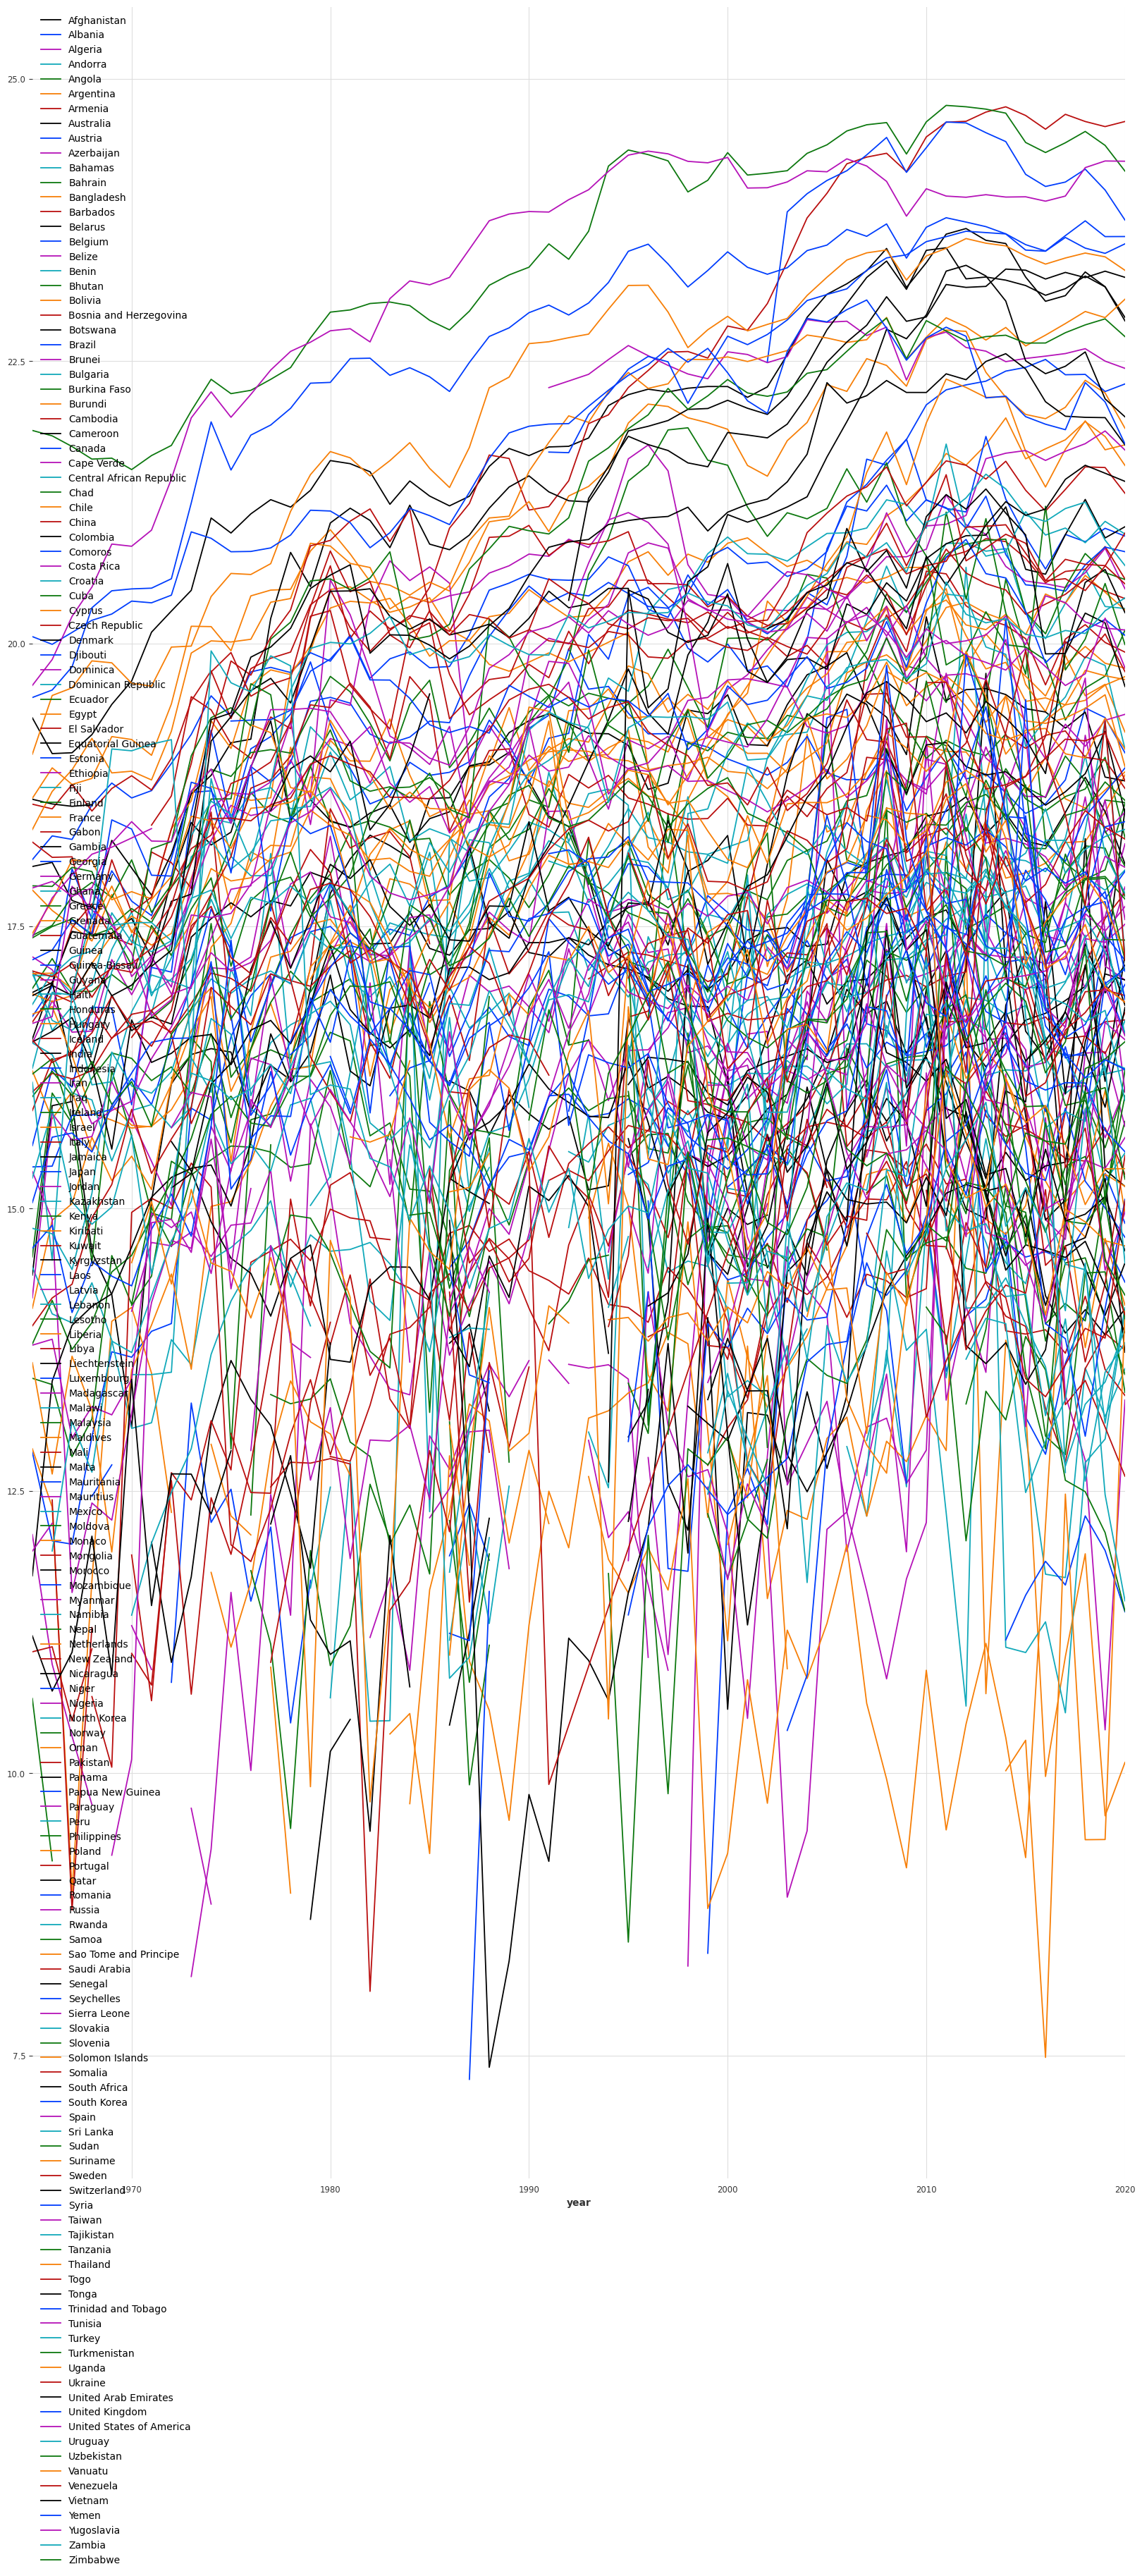

In [290]:
fig, ax = plt.subplots(figsize=(20, 40))
for key, grp in df.groupby('country_d'):
    ax = grp.plot(ax=ax, kind='line', x='year', y='log_all_exports_new', label=key)
#plt.show()

In [291]:
import darts
from darts import TimeSeries
from darts.utils.missing_values import fill_missing_values
from darts.utils.statistics import plot_acf, plot_pacf
from darts.dataprocessing.transformers import Scaler
from darts.models import RNNModel
from darts.models import TCNModel
from darts.models import NBEATSModel
from darts.models import RandomForest
from darts.utils.likelihood_models import GaussianLikelihood
from darts.metrics import mape, mae, rmse, r2_score
from darts.timeseries import concatenate
import torch

In [292]:
import pandas as pd
import numpy as np
from darts import TimeSeries
from darts.dataprocessing.transformers import MissingValuesFiller

# Define year range
full_years = pd.date_range(start="1989-12-31", end="2020-12-31", freq="YE")
full_years_df = pd.DataFrame({"year": full_years})

# Reformat into Darts TimeSeries objects & Split into train/test sets

# Train-test split based on forecast horizon
forecast_horizon = 1  # Forecast 1 year ahead


# Get the last valid time (latest available year) based on your covariate
last_valid_time = df.set_index("year")['distcap'].last_valid_index()

# Compute the train-test split point: leave the last year for testing
split_point = last_valid_time - pd.DateOffset(years=forecast_horizon)

print(f"Split point: {split_point.year}") 

target_series_dict = {}  #
past_covariates_dict = {}  # 


# Initialize lists for train/test sets
train_series_list = []
test_series_list = []
past_covariates_list = []
country_list = []

# need to inspect all countries and remove those with very few observations
df = df[df["country_d"] != "Taiwan"]
df = df[df["country_d"] != "North Korea"]
df = df[df["country_d"] != "Liechtenstein"]
df = df[df["country_d"] != "Monaco"]

for country in df['country_d'].unique():

    country_list.append(country)
    
    # Filter for the current country
    df_country = df[df['country_d'] == country].copy()

    # Step 3: Merge with full years to ensure all dates are present
    df_country = pd.merge(full_years_df, df_country, on="year", how="left")

    # Drop duplicates of rows (see Germany, which part of cleaning went wrong?)
    df_country = df_country.drop_duplicates(subset=["year"], keep="first")

    #Impute missing value
    df_country["log_all_exports_new"] = (
    df_country["log_all_exports_new"]
    .interpolate(method="linear", limit_direction="both")  # fills middle
    .ffill()  # fills head
    .bfill()  # fills tail
    )
    
    # Create TimeSeries objects
    target_series = TimeSeries.from_dataframe(df_country, time_col="year", value_cols=['log_all_exports_new'])
    past_covariates = TimeSeries.from_dataframe(df_country, time_col="year", 
                                                  value_cols=['geodistance', 'distcap', 'gdpcap_d', 'pop_d'])
    
    train_series, test_series = target_series.split_after(split_point)

    train_series_filled = imputer.transform(train_series)
    test_series_filled = imputer.transform(test_series)

    # Convert to float32 for Darts compatibility
    train_series_list.append(train_series_filled.astype(np.float32))
    test_series_list.append(test_series_filled.astype(np.float32))
    past_covariates_list.append(past_covariates.astype(np.float32))

Split point: 2019


In [293]:
print(len(train_series_list))
print(len(train_series_list[2]))
print(len(test_series_list))
print(len(test_series_list[0]))

169
31
169
1


<Axes: xlabel='year'>

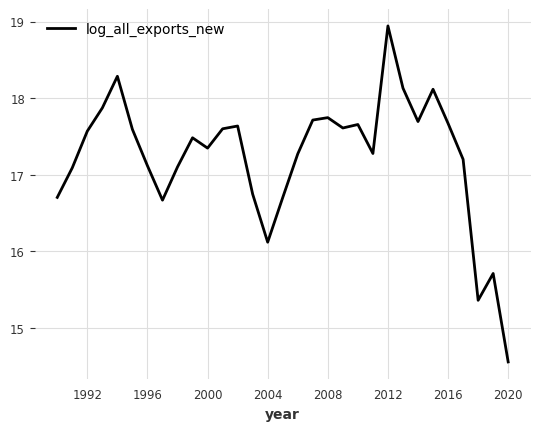

In [294]:
train_series_list[160].plot()

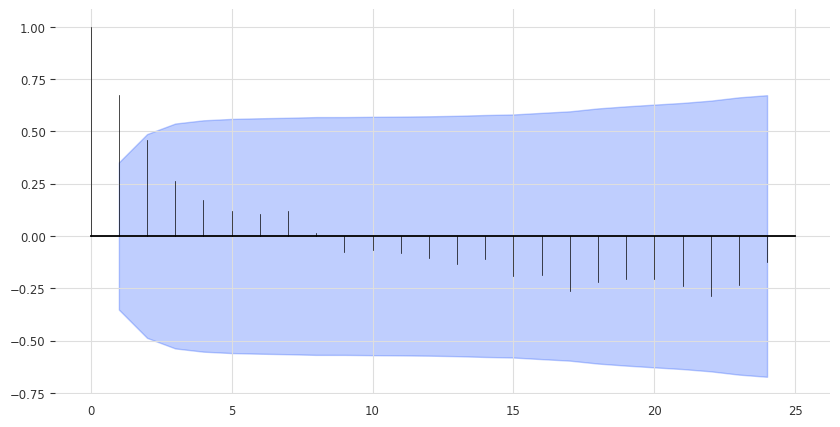

In [295]:
series = train_series_list[8]
plot_acf(series)
#plot_pacf(series)

In [305]:
#random forest predict 2020

predictions_dict = {}  # Country name -> prediction (predicts 2020)

for i, country in enumerate(df['country_d'].unique()):
    train_series = train_series_list[i]
    past_covariates = past_covariates_list[i]

    model = RandomForest(
        lags=[-1, -2, -3],
        lags_past_covariates=[-1, -2, -3],
        output_chunk_length=1
        #model_kwargs={"n_estimators": 200, "max_depth": 8, "random_state": 42}
    )

    if train_series.to_dataframe().isna().sum().sum() > 0:
        print(f"NaNs found in train_series for {country}")
        continue

    model.fit(series=train_series, past_covariates=past_covariates)

    pred = model.predict(n=1, series=train_series, past_covariates=past_covariates)
    
    predictions_dict[country] = pred

for country, pred in predictions_dict.items():
    print(f"{country}: {pred.values()[0][0]}")

Afghanistan: 17.04876564025879
Angola: 18.141145915985106
Albania: 14.051947078704835
Andorra: 13.85251169204712
United Arab Emirates: 22.070975914001465
Argentina: 18.891641998291014
Armenia: 13.544784383773804
Australia: 23.18171365737915
Austria: 19.123791007995607
Azerbaijan: 17.299629640579223
Burundi: 10.843630466461182
Belgium: 22.35176475524902
Benin: 15.482319269180298
Burkina Faso: 14.554671697616577
Bangladesh: 21.860089988708495
Bulgaria: 18.682853202819825
Bahrain: 18.777887630462647
Bahamas: 20.39542158126831
Bosnia and Herzegovina: 13.919997844696045
Belarus: 14.206641626358032
Belize: 15.615271987915039
Bolivia: 15.754143762588502
Brazil: 20.96646541595459
Barbados: 16.46913812637329
Brunei: 21.065266609191895
Bhutan: 15.817121782302856
Botswana: 16.716802673339842
Central African Republic: 12.120380802154541
Canada: 20.934995937347413
Switzerland: 21.42615430831909
Chile: 18.37525526046753
China: 24.62778757095337
Cameroon: 17.10819646835327
Colombia: 18.52578483581543

In [297]:
#random forest predict 2020 MAE

from sklearn.metrics import mean_absolute_error

actual_vs_predicted = {}

for i, country in enumerate(df['country_d'].unique()):
    if country not in predictions_dict:
        continue  # skip if this country was skipped during prediction

    pred_series = predictions_dict[country]  # TimeSeries object
    actual_series = test_series_list[i]      # TimeSeries object
    
    if len(actual_series) == 0:
        print(f"No test data for {country}")
        continue
    
    # Extract scalar values
    y_true = actual_series.values()[0][0]      # First test value
    y_pred = pred_series.values()[0][0]        # First forecast

    error = abs(y_pred - y_true)               # Absolute error (or you can square it for MSE)
    
    actual_vs_predicted[country] = {
        "actual": y_true,
        "predicted": y_pred,
        "error": error
    }

for country, results in actual_vs_predicted.items():
    print(f"{country} - Actual: {results['actual']:.3f}, Predicted: {results['predicted']:.3f}, Error: {results['error']:.3f}")


Afghanistan - Actual: 16.799, Predicted: 17.067, Error: 0.268
Angola - Actual: 18.585, Predicted: 18.146, Error: 0.439
Albania - Actual: 14.347, Predicted: 14.043, Error: 0.305
Andorra - Actual: 13.581, Predicted: 13.845, Error: 0.263
United Arab Emirates - Actual: 21.760, Predicted: 22.079, Error: 0.319
Argentina - Actual: 18.865, Predicted: 18.805, Error: 0.060
Armenia - Actual: 13.745, Predicted: 13.552, Error: 0.193
Australia - Actual: 22.857, Predicted: 23.211, Error: 0.354
Austria - Actual: 19.033, Predicted: 19.094, Error: 0.060
Azerbaijan - Actual: 17.845, Predicted: 17.408, Error: 0.438
Burundi - Actual: 10.095, Predicted: 10.647, Error: 0.552
Belgium - Actual: 22.299, Predicted: 22.341, Error: 0.043
Benin - Actual: 15.491, Predicted: 15.641, Error: 0.150
Burkina Faso - Actual: 15.770, Predicted: 14.621, Error: 1.149
Bangladesh - Actual: 21.578, Predicted: 21.862, Error: 0.284
Bulgaria - Actual: 17.232, Predicted: 18.673, Error: 1.441
Bahrain - Actual: 18.283, Predicted: 18.73

In [298]:
#random forest predict 2020 mean MAE across countries

all_actuals = [v['actual'] for v in actual_vs_predicted.values()]
all_preds = [v['predicted'] for v in actual_vs_predicted.values()]

mae = mean_absolute_error(all_actuals, all_preds)

print(f"\nOverall Mean Absolute Error: {mae:.4f}")


Overall Mean Absolute Error: 0.4713


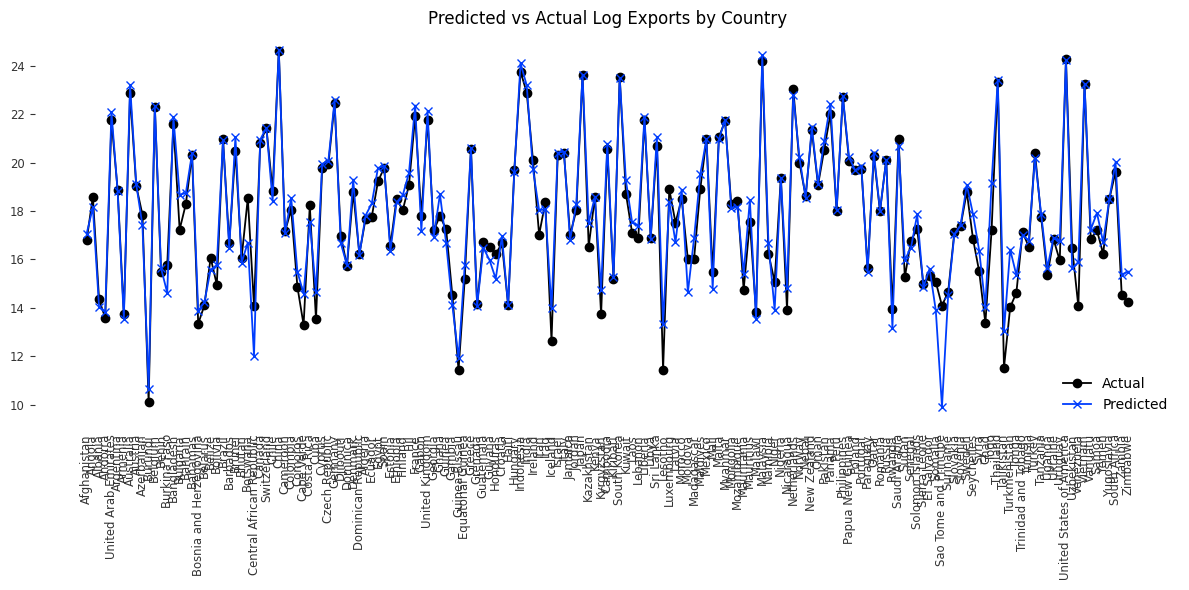

In [299]:
#random forest predict 2020 predicted vs actual

import matplotlib.pyplot as plt

countries = list(actual_vs_predicted.keys())
actual = [actual_vs_predicted[c]['actual'] for c in countries]
predicted = [actual_vs_predicted[c]['predicted'] for c in countries]

plt.figure(figsize=(12, 6))
plt.plot(countries, actual, label="Actual", marker='o')
plt.plot(countries, predicted, label="Predicted", marker='x')
plt.xticks(rotation=90)
plt.title("Predicted vs Actual Log Exports by Country")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

In [300]:
#random forest predict 2020 overall MSE and RMSE

from sklearn.metrics import mean_squared_error
import numpy as np

# Extract predictions and ground truth values
all_actuals = [v['actual'] for v in actual_vs_predicted.values()]
all_preds = [v['predicted'] for v in actual_vs_predicted.values()]

# Compute MSE
mse = mean_squared_error(all_actuals, all_preds)

# Compute RMSE
rmse = np.sqrt(mse)

# Print results
print(f"\nMean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")



Mean Squared Error (MSE): 0.5120
Root Mean Squared Error (RMSE): 0.7155


In [301]:
#random forest predict 2020 MSE and RMSE by country

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error
import numpy as np

# Dictionary to store per-country evaluation metrics
metrics_by_country = {}

# Per-country metrics
for country, results in actual_vs_predicted.items():
    y_true = results['actual']
    y_pred = results['predicted']
    
    mse = (y_true - y_pred) ** 2
    rmse = np.sqrt(mse)
    #r2 = r2_score([y_true], [y_pred])  # single-value R² returns 1.0 by definition
    mape = mean_absolute_percentage_error([y_true], [y_pred])
    
    metrics_by_country[country] = {
        'MSE': mse,
        'RMSE': rmse,
        #'R2': r2,
        'MAPE': mape
    }

# Print per-country metrics
print("📊 Per-country Metrics:")
for country, metrics in metrics_by_country.items():
    print(f"{country}: MSE={metrics['MSE']:.4f}, RMSE={metrics['RMSE']:.4f}, MAPE={metrics['MAPE']*100:.2f}%")

# Aggregate global metrics (averaged)
all_mse = [m['MSE'] for m in metrics_by_country.values()]
all_rmse = [m['RMSE'] for m in metrics_by_country.values()]
#all_r2 = [m['R2'] for m in metrics_by_country.values()]
all_mape = [m['MAPE'] for m in metrics_by_country.values()]

avg_mse = np.mean(all_mse)
avg_rmse = np.mean(all_rmse)
#avg_r2 = np.mean(all_r2)
avg_mape = np.mean(all_mape)

print("\n🌍 Global Average Metrics:")
print(f"Average MSE: {avg_mse:.4f}")
print(f"Average RMSE: {avg_rmse:.4f}")
#print(f"Average R²: {avg_r2:.4f}")
print(f"Average MAPE: {avg_mape*100:.2f}%")


📊 Per-country Metrics:
Afghanistan: MSE=0.0716, RMSE=0.2676, MAPE=1.59%
Angola: MSE=0.1927, RMSE=0.4390, MAPE=2.36%
Albania: MSE=0.0929, RMSE=0.3048, MAPE=2.12%
Andorra: MSE=0.0694, RMSE=0.2635, MAPE=1.94%
United Arab Emirates: MSE=0.1018, RMSE=0.3191, MAPE=1.47%
Argentina: MSE=0.0036, RMSE=0.0598, MAPE=0.32%
Armenia: MSE=0.0374, RMSE=0.1933, MAPE=1.41%
Australia: MSE=0.1254, RMSE=0.3542, MAPE=1.55%
Austria: MSE=0.0037, RMSE=0.0604, MAPE=0.32%
Azerbaijan: MSE=0.1917, RMSE=0.4378, MAPE=2.45%
Burundi: MSE=0.3047, RMSE=0.5520, MAPE=5.47%
Belgium: MSE=0.0018, RMSE=0.0426, MAPE=0.19%
Benin: MSE=0.0224, RMSE=0.1497, MAPE=0.97%
Burkina Faso: MSE=1.3212, RMSE=1.1494, MAPE=7.29%
Bangladesh: MSE=0.0808, RMSE=0.2843, MAPE=1.32%
Bulgaria: MSE=2.0772, RMSE=1.4412, MAPE=8.36%
Bahrain: MSE=0.2041, RMSE=0.4517, MAPE=2.47%
Bahamas: MSE=0.0043, RMSE=0.0658, MAPE=0.32%
Bosnia and Herzegovina: MSE=0.2752, RMSE=0.5246, MAPE=3.93%
Belarus: MSE=0.0172, RMSE=0.1310, MAPE=0.93%
Belize: MSE=0.2412, RMSE=0.4911,

In [302]:
#random forest predicted for 2021

from darts.models import RandomForest

predictions_dict = {}  # Country name -> 2021 forecast

# Use safe lag configs (e.g. past 3 years)
lags = [-1, -2, -3]
lags_cov = [-1, -2, -3]

for i, country in enumerate(country_list):  # use pre-cleaned country_list

    series = train_series_list[i]  # up to 2020
    covariates = past_covariates_list[i]  # must match index and go to 2020

    # Train model on full series
    model = RandomForest(
        lags=lags,
        lags_past_covariates=lags_cov,
        output_chunk_length=1,
        n_jobs=-1
    )

    try:
        model.fit(series=series, past_covariates=covariates)

        # Forecast 1 step into the future (2021)
        forecast = model.predict(n=1, series=series, past_covariates=covariates)

        predictions_dict[country] = forecast
    except Exception as e:
        print(f"{country}: Forecasting failed → {e}")
        continue

# Print the forecasts for 2021
for country, pred in predictions_dict.items():
    val = pred.values()[0][0]
    print(f"{country} - Forecasted log(exports) for 2021: {val:.4f}")


Afghanistan - Forecasted log(exports) for 2021: 17.0832
Angola - Forecasted log(exports) for 2021: 18.1702
Albania - Forecasted log(exports) for 2021: 14.1090
Andorra - Forecasted log(exports) for 2021: 13.8324
United Arab Emirates - Forecasted log(exports) for 2021: 22.0533
Argentina - Forecasted log(exports) for 2021: 18.8304
Armenia - Forecasted log(exports) for 2021: 13.5444
Australia - Forecasted log(exports) for 2021: 23.1724
Austria - Forecasted log(exports) for 2021: 19.1153
Azerbaijan - Forecasted log(exports) for 2021: 17.4100
Burundi - Forecasted log(exports) for 2021: 10.6993
Belgium - Forecasted log(exports) for 2021: 22.3549
Benin - Forecasted log(exports) for 2021: 15.5542
Burkina Faso - Forecasted log(exports) for 2021: 14.5710
Bangladesh - Forecasted log(exports) for 2021: 21.8842
Bulgaria - Forecasted log(exports) for 2021: 18.5172
Bahrain - Forecasted log(exports) for 2021: 18.7663
Bahamas - Forecasted log(exports) for 2021: 20.4418
Bosnia and Herzegovina - Forecaste

In [308]:
# Step 1: Extract 2020 rows only (assumes 'year' is datetime)
df_2020 = df[df["year"] == pd.Timestamp("2020-12-31")].copy()

# Step 2: Add the predicted log(export) for 2021
df_2020["predicted_log_export_2021"] = df_2020["country_d"].map(
    lambda country: predictions_dict[country].values()[0][0] if country in predictions_dict else np.nan
)

# Step 3: Un-log to get predicted export volume for 2021
df_2020["predicted_export_2021"] = np.exp(df_2020["predicted_log_export_2021"])

# Step 4: Compute actual export volume for 2020
df_2020["export_2020"] = df_2020["all_exports_new"]

# Step 5: Calculate predicted change in export
df_2020["change_in_export"] = df_2020["predicted_export_2021"] - df_2020["export_2020"]

# Step 6: Rank countries by predicted export change
df_2020["rank_change_in_export"] = df_2020["change_in_export"].rank(ascending=False).astype(int)

# New: Rank countries based on 'geodistance' → lower is better
df_2020["rank_geopolitical_distance"] = df_2020["geodistance"].rank(ascending=True).astype(int)

# New: Rank countries based on 'dist' → lower is better
df_2020["rank_dist"] = df_2020["dist"].rank(ascending=True).astype(int)

# New: Rank countries based on 'pop_d' → higher is better
df_2020["rank_pop"] = df_2020["pop_d"].rank(ascending=False).astype(int)

# Final composite score: average of the 4 ranks
df_2020["final_rank_score"] = (
    0.25 * df_2020["rank_change_in_export"]
    + 0.25 * df_2020["rank_geopolitical_distance"]
    + 0.25 * df_2020["rank_dist"]
    + 0.25 * df_2020["rank_pop"]
)

# Optional: Final rank based on that composite score
df_2020["final_rank"] = df_2020["final_rank_score"].rank().astype(int)

# Sort by final rank
df_ranked = df_2020.sort_values("final_rank")

# Display relevant columns
df_ranked[[
    "country_d", 
    "predicted_export_2021", 
    "export_2020", 
    "change_in_export", 
    "rank_change_in_export", 
    "rank_geopolitical_distance", 
    "rank_dist", 
    "rank_pop", 
    "final_rank_score", 
    "final_rank"
]]


country_d  predicted_export_2021   export_2020  \
3501                  India           1.175384e+10  8.710406e+09   
3445              Indonesia           2.878741e+10  2.062711e+10   
1523                  China           4.962634e+10  4.935476e+10   
6182            Philippines           7.565411e+09  7.351197e+09   
5491               Malaysia           4.080378e+10  3.181143e+10   
...                     ...                    ...           ...   
3285               Honduras           3.932666e+06  1.114764e+07   
1727             Cape Verde           1.149581e+06  5.990090e+05   
6977  Sao Tome and Principe           1.805724e+04  1.314261e+06   
184                 Andorra           1.037694e+06  7.910690e+05   
7023               Suriname           2.240345e+06  2.346906e+06   

      change_in_export  rank_change_in_export  rank_geopolitical_distance  \
3501      3.043431e+09                      4                           2   
3445      8.160305e+09                      2                          18   
1523      2.715813e+08                     19                           3   
6182      2.142143e+08                     21                           1   
5491      8.992354e+09                      1                           4   
...                ...                    ...                         ...   
3285     -7.214974e+06                    142                         138   
1727      5.505722e+05                     98                         150   
6977     -1.296204e+06                    121                         141   
184       2.466252e+05                    101                         166   
7023     -1.065614e+05                    110                         151   

      rank_dist  rank_pop  final_rank_score  final_rank  
3501         16         2              6.00           1  
3445          2         4              6.50           2  
1523         15         1              9.50           3  
6182          9        13             11.00           4  
5491          1        44             12.50           5  
...         ...       ...               ...         ...  
3285        159        87            131.50         164  
1727        137       152            134.25         165  
6977        114       161            134.25         165  
184         117       167            137.75         167  
7023        150       151            140.50         168  

[168 rows x 10 columns]

In [278]:
#random forest Rolling window = 20 years, overall MAPE, MSE, RMSE

from darts.metrics import mape, mse, rmse, r2_score
from darts.models import RandomForest
from darts.dataprocessing.transformers import MissingValuesFiller
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score as skl_r2
from tqdm import tqdm
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# MAPE manually
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

forecast_horizon = 1
min_train_years = 20  # window size

metrics_dict = {
    "country": [],
    "mape": [],
    "mse": [],
    "rmse": [],
    #"r2": []
}

imputer = MissingValuesFiller()

for country in df['country_d'].unique():
    df_country = df[df['country_d'] == country].copy()
    df_country = pd.merge(full_years_df, df_country, on="year", how="left")
    df_country = df_country.drop_duplicates(subset=["year"], keep="first")
    
    # Impute missing values
    df_country["log_all_exports_new"] = (
        df_country["log_all_exports_new"]
        .interpolate(method="linear", limit_direction="both")
        .ffill()
        .bfill()
    )
    
    target_series = TimeSeries.from_dataframe(df_country, time_col="year", value_cols=['log_all_exports_new'])
    past_covariates = TimeSeries.from_dataframe(df_country, time_col="year", 
                        value_cols=['geodistance', 'distcap', 'gdpcap_d', 'pop_d'])
    
    # Impute missing values in the target series
    target_series = imputer.transform(target_series)
    past_covariates = imputer.transform(past_covariates)
    
    # Rolling Window Forecasting
    start_idx = min_train_years
    total_points = len(target_series) - forecast_horizon -1

    y_true = []
    y_pred = []

    for i in range(start_idx, total_points):
        train_series = target_series[:i+1]
        val_series = target_series[i+1:i+1 + forecast_horizon]
        
        train_cov = past_covariates[:i+1]
        val_cov = past_covariates[:i+1 + forecast_horizon]
        
        model = RandomForest(
            lags=[-1, -2, -3],
            lags_past_covariates=[-1, -2, -3],
            output_chunk_length=forecast_horizon
        )

        try:
            model.fit(series=train_series, past_covariates=train_cov)
            pred = model.predict(n=forecast_horizon, series=train_series, past_covariates=val_cov)
            y_true.append(val_series.values()[0][0])
            y_pred.append(pred.values()[0][0])
        except Exception as e:
            print(f"Skipping year {target_series.time_index[i]} for {country} due to error: {e}")
            continue

    # Skip if not enough data
    if len(y_true) < 3:
        continue


# Then in your loop:
    metrics_dict["mape"].append(mean_absolute_percentage_error(y_true, y_pred))
    metrics_dict["mse"].append(mean_squared_error(y_true, y_pred))
    metrics_dict["rmse"].append(np.sqrt(mean_squared_error(y_true, y_pred)))
    #metrics_dict["r2"].append(r2_score(y_true, y_pred))

# Now calculate and print average metrics across all countries
avg_mape = np.mean(metrics_dict["mape"])
avg_mse = np.mean(metrics_dict["mse"])
avg_rmse = np.mean(metrics_dict["rmse"])
#avg_r2 = np.mean(metrics_dict["r2"])

print("\n--- Average Metrics Across All Countries ---")
print(f"Mean Absolute Percentage Error (MAPE): {avg_mape:.2f}%")
print(f"Mean Squared Error (MSE): {avg_mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {avg_rmse:.4f}")
#print(f"R² Score: {avg_r2:.4f}")


--- Average Metrics Across All Countries ---
Mean Absolute Percentage Error (MAPE): 3.04%
Mean Squared Error (MSE): 0.5968
Root Mean Squared Error (RMSE): 0.6231


In [279]:
from darts.models import XGBModel

# Predict 2020 using XGBoost
predictions_dict = {}

for i, country in enumerate(df['country_d'].unique()):
    train_series = train_series_list[i]
    past_covariates = past_covariates_list[i]

    model = XGBModel(
        lags=[-1, -2, -3],
        lags_past_covariates=[-1, -2, -3],
        output_chunk_length=1,
        random_state=42,
        n_estimators=200,
        max_depth=8
    )

    # Optionally skip countries with NaNs
    # if train_series.pd_dataframe().isna().sum().sum() > 0:
    #     print(f"NaNs found in train_series for {country}")
    #     continue

    model.fit(series=train_series, past_covariates=past_covariates)

    pred = model.predict(n=1, series=train_series, past_covariates=past_covariates)

    predictions_dict[country] = pred

# Print predictions for 2020
for country, pred in predictions_dict.items():
    print(f"{country}: {pred.values()[0][0]}")


Afghanistan: 17.28345489501953
Angola: 18.05229949951172
Albania: 14.7151460647583
Andorra: 13.530316352844238
United Arab Emirates: 21.986799240112305
Argentina: 18.947368621826172
Armenia: 13.671055793762207
Australia: 23.17144775390625
Austria: 18.983383178710938
Azerbaijan: 17.363927841186523
Burundi: 9.972190856933594
Belgium: 22.419391632080078
Benin: 15.278597831726074
Burkina Faso: 14.13349437713623
Bangladesh: 21.833715438842773
Bulgaria: 19.14122772216797
Bahrain: 18.927194595336914
Bahamas: 20.325626373291016
Bosnia and Herzegovina: 14.175782203674316
Belarus: 13.906889915466309
Belize: 15.270318031311035
Bolivia: 15.829849243164062
Brazil: 21.009151458740234
Barbados: 17.019569396972656
Brunei: 21.07405662536621
Bhutan: 15.654293060302734
Botswana: 16.880529403686523
Central African Republic: 11.372539520263672
Canada: 20.658185958862305
Switzerland: 21.42616081237793
Chile: 17.979759216308594
China: 24.59897232055664
Cameroon: 16.677270889282227
Colombia: 18.51238059997558

In [280]:
#XGBoost predict 2020 MAE

from sklearn.metrics import mean_absolute_error

actual_vs_predicted = {}

for i, country in enumerate(df['country_d'].unique()):
    if country not in predictions_dict:
        continue  # skip if this country was skipped during prediction

    pred_series = predictions_dict[country]  # TimeSeries object
    actual_series = test_series_list[i]      # TimeSeries object
    
    if len(actual_series) == 0:
        print(f"No test data for {country}")
        continue
    
    # Extract scalar values
    y_true = actual_series.values()[0][0]      # First test value
    y_pred = pred_series.values()[0][0]        # First forecast

    error = abs(y_pred - y_true)               # Absolute error (or you can square it for MSE)
    
    actual_vs_predicted[country] = {
        "actual": y_true,
        "predicted": y_pred,
        "error": error
    }

for country, results in actual_vs_predicted.items():
    print(f"{country} - Actual: {results['actual']:.3f}, Predicted: {results['predicted']:.3f}, Error: {results['error']:.3f}")

Afghanistan - Actual: 16.799, Predicted: 17.283, Error: 0.484
Angola - Actual: 18.585, Predicted: 18.052, Error: 0.533
Albania - Actual: 14.347, Predicted: 14.715, Error: 0.368
Andorra - Actual: 13.581, Predicted: 13.530, Error: 0.051
United Arab Emirates - Actual: 21.760, Predicted: 21.987, Error: 0.227
Argentina - Actual: 18.865, Predicted: 18.947, Error: 0.083
Armenia - Actual: 13.745, Predicted: 13.671, Error: 0.074
Australia - Actual: 22.857, Predicted: 23.171, Error: 0.314
Austria - Actual: 19.033, Predicted: 18.983, Error: 0.050
Azerbaijan - Actual: 17.845, Predicted: 17.364, Error: 0.482
Burundi - Actual: 10.095, Predicted: 9.972, Error: 0.123
Belgium - Actual: 22.299, Predicted: 22.419, Error: 0.121
Benin - Actual: 15.491, Predicted: 15.279, Error: 0.212
Burkina Faso - Actual: 15.770, Predicted: 14.133, Error: 1.637
Bangladesh - Actual: 21.578, Predicted: 21.834, Error: 0.256
Bulgaria - Actual: 17.232, Predicted: 19.141, Error: 1.909
Bahrain - Actual: 18.283, Predicted: 18.927

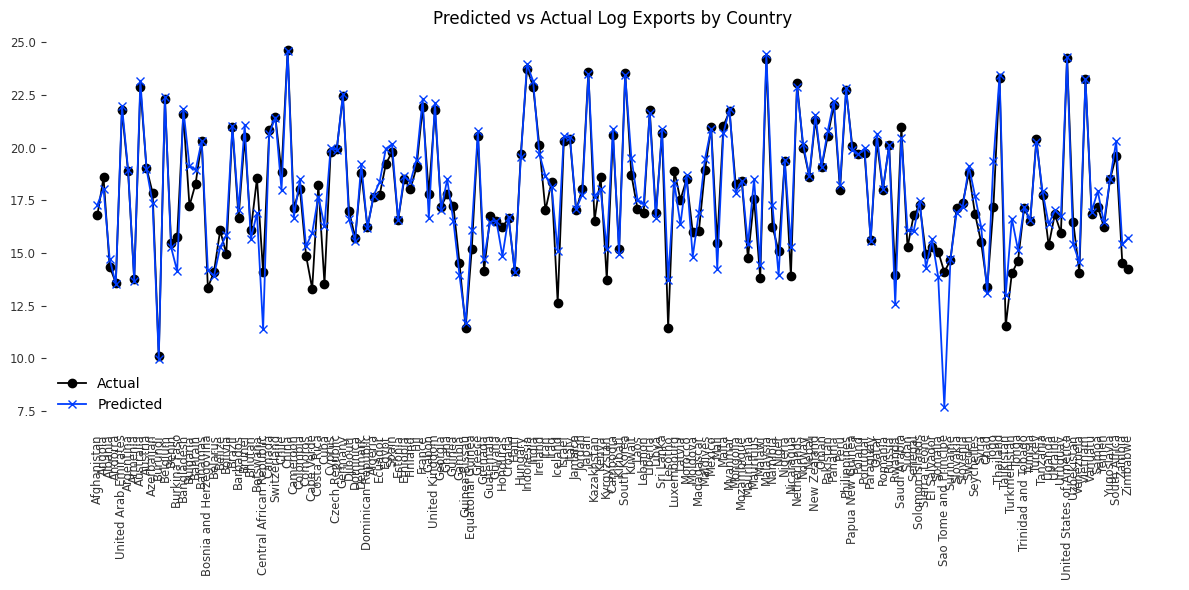

In [281]:
#XGBoost predict 2020 predicted vs actual

import matplotlib.pyplot as plt

countries = list(actual_vs_predicted.keys())
actual = [actual_vs_predicted[c]['actual'] for c in countries]
predicted = [actual_vs_predicted[c]['predicted'] for c in countries]

plt.figure(figsize=(12, 6))
plt.plot(countries, actual, label="Actual", marker='o')
plt.plot(countries, predicted, label="Predicted", marker='x')
plt.xticks(rotation=90)
plt.title("Predicted vs Actual Log Exports by Country")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

In [282]:
#XG Boost predict 2020 overall MSE and RMSE

from sklearn.metrics import mean_squared_error
import numpy as np

# Extract predictions and ground truth values
all_actuals = [v['actual'] for v in actual_vs_predicted.values()]
all_preds = [v['predicted'] for v in actual_vs_predicted.values()]

# Compute MSE
mse = mean_squared_error(all_actuals, all_preds)

# Compute RMSE
rmse = np.sqrt(mse)

# Print results
print(f"\nMean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")


Mean Squared Error (MSE): 0.8643
Root Mean Squared Error (RMSE): 0.9297


In [283]:
#XGBoost predict 2020 MSE and RMSE by country

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error
import numpy as np

# Dictionary to store per-country evaluation metrics
metrics_by_country = {}

# Per-country metrics
for country, results in actual_vs_predicted.items():
    y_true = results['actual']
    y_pred = results['predicted']
    
    mse = (y_true - y_pred) ** 2
    rmse = np.sqrt(mse)
    #r2 = r2_score([y_true], [y_pred])  # single-value R² returns 1.0 by definition
    mape = mean_absolute_percentage_error([y_true], [y_pred])
    
    metrics_by_country[country] = {
        'MSE': mse,
        'RMSE': rmse,
        #'R2': r2,
        'MAPE': mape
    }

# Print per-country metrics
print("📊 Per-country Metrics:")
for country, metrics in metrics_by_country.items():
    print(f"{country}: MSE={metrics['MSE']:.4f}, RMSE={metrics['RMSE']:.4f}, MAPE={metrics['MAPE']*100:.2f}%")

# Aggregate global metrics (averaged)
all_mse = [m['MSE'] for m in metrics_by_country.values()]
all_rmse = [m['RMSE'] for m in metrics_by_country.values()]
#all_r2 = [m['R2'] for m in metrics_by_country.values()]
all_mape = [m['MAPE'] for m in metrics_by_country.values()]

avg_mse = np.mean(all_mse)
avg_rmse = np.mean(all_rmse)
#avg_r2 = np.mean(all_r2)
avg_mape = np.mean(all_mape)

print("\n🌍 Global Average Metrics:")
print(f"Average MSE: {avg_mse:.4f}")
print(f"Average RMSE: {avg_rmse:.4f}")
#print(f"Average R²: {avg_r2:.4f}")
print(f"Average MAPE: {avg_mape*100:.2f}%")

📊 Per-country Metrics:
Afghanistan: MSE=0.2345, RMSE=0.4843, MAPE=2.88%
Angola: MSE=0.2842, RMSE=0.5331, MAPE=2.87%
Albania: MSE=0.1353, RMSE=0.3678, MAPE=2.56%
Andorra: MSE=0.0026, RMSE=0.0508, MAPE=0.37%
United Arab Emirates: MSE=0.0516, RMSE=0.2272, MAPE=1.04%
Argentina: MSE=0.0068, RMSE=0.0827, MAPE=0.44%
Armenia: MSE=0.0055, RMSE=0.0744, MAPE=0.54%
Australia: MSE=0.0988, RMSE=0.3142, MAPE=1.37%
Austria: MSE=0.0025, RMSE=0.0500, MAPE=0.26%
Azerbaijan: MSE=0.2319, RMSE=0.4815, MAPE=2.70%
Burundi: MSE=0.0152, RMSE=0.1232, MAPE=1.22%
Belgium: MSE=0.0145, RMSE=0.1205, MAPE=0.54%
Benin: MSE=0.0451, RMSE=0.2124, MAPE=1.37%
Burkina Faso: MSE=2.6785, RMSE=1.6366, MAPE=10.38%
Bangladesh: MSE=0.0655, RMSE=0.2560, MAPE=1.19%
Bulgaria: MSE=3.6452, RMSE=1.9092, MAPE=11.08%
Bahrain: MSE=0.4144, RMSE=0.6437, MAPE=3.52%
Bahamas: MSE=0.0002, RMSE=0.0142, MAPE=0.07%
Bosnia and Herzegovina: MSE=0.6912, RMSE=0.8314, MAPE=6.23%
Belarus: MSE=0.0415, RMSE=0.2038, MAPE=1.44%
Belize: MSE=0.6349, RMSE=0.796

In [284]:
XGBoost forecast 2021

from darts.models import XGBModel

predictions_dict = {}  # Country name -> 2021 forecast

# Use safe lag configs (e.g. past 3 years)
lags = [-1, -2, -3]
lags_cov = [-1, -2, -3]

for i, country in enumerate(country_list):  # use pre-cleaned country_list

    series = train_series_list[i]  # up to 2020
    covariates = past_covariates_list[i]  # must match index and go to 2020

    model = XGBModel(
        lags=lags,
        lags_past_covariates=lags_cov,
        output_chunk_length=1,
        n_estimators=200,
        max_depth=8,
        random_state=42,
        n_jobs=-1
    )

    try:
        model.fit(series=series, past_covariates=covariates)

        # Forecast 1 step into the future (2021)
        forecast = model.predict(n=1, series=series, past_covariates=covariates)

        predictions_dict[country] = forecast
    except Exception as e:
        print(f"{country}: Forecasting failed → {e}")
        continue

# Print the forecasts for 2021
for country, pred in predictions_dict.items():
    val = pred.values()[0][0]
    print(f"{country} - Forecasted log(exports) for 2021: {val:.4f}")


Afghanistan - Forecasted log(exports) for 2021: 17.2835
Angola - Forecasted log(exports) for 2021: 18.0523
Albania - Forecasted log(exports) for 2021: 14.7151
Andorra - Forecasted log(exports) for 2021: 13.5303
United Arab Emirates - Forecasted log(exports) for 2021: 21.9868
Argentina - Forecasted log(exports) for 2021: 18.9474
Armenia - Forecasted log(exports) for 2021: 13.6711
Australia - Forecasted log(exports) for 2021: 23.1714
Austria - Forecasted log(exports) for 2021: 18.9834
Azerbaijan - Forecasted log(exports) for 2021: 17.3639
Burundi - Forecasted log(exports) for 2021: 9.9722
Belgium - Forecasted log(exports) for 2021: 22.4194
Benin - Forecasted log(exports) for 2021: 15.2786
Burkina Faso - Forecasted log(exports) for 2021: 14.1335
Bangladesh - Forecasted log(exports) for 2021: 21.8337
Bulgaria - Forecasted log(exports) for 2021: 19.1412
Bahrain - Forecasted log(exports) for 2021: 18.9272
Bahamas - Forecasted log(exports) for 2021: 20.3256
Bosnia and Herzegovina - Forecasted

In [285]:
#random forest Rolling window = 20 years, overall MAPE, MSE, RMSE

from darts.metrics import mape, mse, rmse, r2_score
from darts.models import RandomForest
from darts.dataprocessing.transformers import MissingValuesFiller
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score as skl_r2
from tqdm import tqdm
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# MAPE manually
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

forecast_horizon = 1
min_train_years = 20  # window size

metrics_dict = {
    "country": [],
    "mape": [],
    "mse": [],
    "rmse": [],
    #"r2": []
}

imputer = MissingValuesFiller()

for country in df['country_d'].unique():
    df_country = df[df['country_d'] == country].copy()
    df_country = pd.merge(full_years_df, df_country, on="year", how="left")
    df_country = df_country.drop_duplicates(subset=["year"], keep="first")
    
    # Impute missing values
    df_country["log_all_exports_new"] = (
        df_country["log_all_exports_new"]
        .interpolate(method="linear", limit_direction="both")
        .ffill()
        .bfill()
    )
    
    target_series = TimeSeries.from_dataframe(df_country, time_col="year", value_cols=['log_all_exports_new'])
    past_covariates = TimeSeries.from_dataframe(df_country, time_col="year", 
                        value_cols=['geodistance', 'distcap', 'gdpcap_d', 'pop_d'])
    
    # Impute missing values in the target series
    target_series = imputer.transform(target_series)
    past_covariates = imputer.transform(past_covariates)
    
    # Rolling Window Forecasting
    start_idx = min_train_years
    total_points = len(target_series) - forecast_horizon -1

    y_true = []
    y_pred = []

    for i in range(start_idx, total_points):
        train_series = target_series[:i+1]
        val_series = target_series[i+1:i+1 + forecast_horizon]
        
        train_cov = past_covariates[:i+1]
        val_cov = past_covariates[:i+1 + forecast_horizon]
        
        model = XGBModel(
            lags=[-1, -2, -3],
            lags_past_covariates=[-1, -2, -3],
            output_chunk_length=forecast_horizon,
            n_estimators=200,
            max_depth=8,
            random_state=42
        )

        try:
            model.fit(series=train_series, past_covariates=train_cov)
            pred = model.predict(n=forecast_horizon, series=train_series, past_covariates=val_cov)
            y_true.append(val_series.values()[0][0])
            y_pred.append(pred.values()[0][0])
        except Exception as e:
            print(f"Skipping year {target_series.time_index[i]} for {country} due to error: {e}")
            continue

    # Skip if not enough data
    if len(y_true) < 3:
        continue


# Then in your loop:
    metrics_dict["mape"].append(mean_absolute_percentage_error(y_true, y_pred))
    metrics_dict["mse"].append(mean_squared_error(y_true, y_pred))
    metrics_dict["rmse"].append(np.sqrt(mean_squared_error(y_true, y_pred)))
    #metrics_dict["r2"].append(r2_score(y_true, y_pred))

# Now calculate and print average metrics across all countries
avg_mape = np.mean(metrics_dict["mape"])
avg_mse = np.mean(metrics_dict["mse"])
avg_rmse = np.mean(metrics_dict["rmse"])
#avg_r2 = np.mean(metrics_dict["r2"])

print("\n--- Average Metrics Across All Countries ---")
print(f"Mean Absolute Percentage Error (MAPE): {avg_mape:.2f}%")
print(f"Mean Squared Error (MSE): {avg_mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {avg_rmse:.4f}")
#print(f"R² Score: {avg_r2:.4f}")


--- Average Metrics Across All Countries ---
Mean Absolute Percentage Error (MAPE): 3.42%
Mean Squared Error (MSE): 0.8826
Root Mean Squared Error (RMSE): 0.7095
